In [150]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import os
from matplotlib import pyplot as plt

In [151]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 400

# batch
batch_size = 512

In [152]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [153]:
# 1. READ THE DATA

# data_dir='../../data_colony/'
# data_dir='../../data_single/'
data_dir='../../data_indiv/' # after fixed
# data_dir = '../../hymenoptera_data/hymenoptera_data/'

train_dataset=torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])

In [154]:
val_dataset=torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])

In [155]:
train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader=torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [156]:
for images, labels in train_loader:
    print(images.size()) # loaded tensors
    print(images[0].size()) # first batch
    print(labels.size())
    break

torch.Size([512, 3, 400, 400])
torch.Size([3, 400, 400])
torch.Size([512])


In [157]:

# features = nn.Sequential(
#             nn.Conv2d(3,32,kernel_size=5, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(32,64,kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64,128,kernel_size=5, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128,128,kernel_size=5, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
# )


features = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=5, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16,32,kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32,64,kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,128,kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
)

In [158]:
fc_size=features(images).view(images.size(0),-1).size()[1]
print(fc_size)

2048


In [159]:
num_classes = 2

In [160]:
# 2. DEFINE THE NETWORK: by mimicking AlexNet

# previous net

# class AlexNet(nn.Module):
#     def __init__(self, num_classes, fc_size):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3,32,kernel_size=5, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(32,64,kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64,128,kernel_size=5, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128,128,kernel_size=5, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#          )
# #         self.classifier = nn.Linear(256, num_classes)
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=0.5),
#             nn.Linear(fc_size, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 512),
#             nn.ReLU(inplace=True),
#             nn.Linear(512, num_classes)
#         )
class AlexNet(nn.Module):
    def __init__(self, num_classes, fc_size):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=5, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16,32,kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32,64,kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,128,kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
         )
#         self.classifier = nn.Linear(256, num_classes)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(fc_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [161]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# net = AlexNet().to(device)
net = AlexNet(num_classes, fc_size).to(device)
# print(device)

In [162]:
# 3 & 4. DEFINE LOSS FUNCTION AND OPTIMIZATION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [163]:
# 5. TRAIN THE NETWORK

num_epochs = 20

train_loss_list = [] # make an empty list for later use
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0 # set initial values for all the epoch
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    ##### train #####
    net.train()  # transform into training mode 
    # read by mini batch
    for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.view(-1, 32*32*3).to(device), labels.to(device) # transform into 1D and transfer to GPU
        images, labels = images.to(device), labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
        optimizer.zero_grad() # initialize the gradient
        outputs = net(images) # feedforward calculation
        loss = criterion(outputs, labels)
        train_loss +=loss.item()
        train_acc += (outputs.max(1)[1]==labels).sum().item()
        loss.backward() # backpropagation calculation
        optimizer.step() 

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    ##### evaluation #####
    net.eval() # switch to evaluation mode
    with torch.no_grad(): # gradient calculation is not required for the evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
            
        print("Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}".format
                  (epoch+1, num_epochs, i+1, loss = avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
            
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)



Epoch [1/20], Loss: 0.0014, val_loss: 0.0014, val_acc: 0.5366
Epoch [2/20], Loss: 0.0014, val_loss: 0.0014, val_acc: 0.5366
Epoch [3/20], Loss: 0.0014, val_loss: 0.0014, val_acc: 0.5366


KeyboardInterrupt: 

In [ ]:
# add 1 more Conv (16-32-64-128)
# image size: 300
# batch size: 256->512
# after fixed
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

###### result:  /20, 0.


(0.3, 1.0)

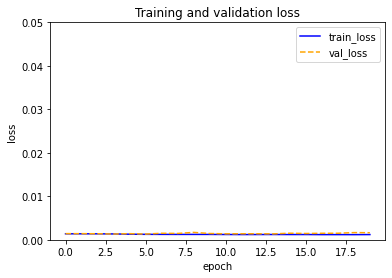

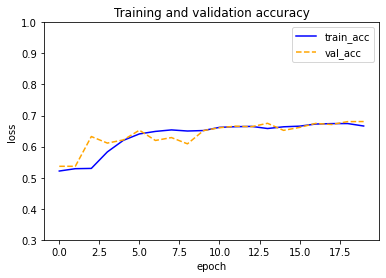

In [108]:
# image size: 300 -> 100
# batch size: 256->512
# after fixed
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

###### result:  /20, 0.

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'orange', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
# plt.grid()
plt.ylim([0, 0.05])
plt.legend(loc='best')


plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'orange', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
# plt.grid()
plt.ylim([0.3, 1.0])

In [ ]:
# image size: 300 -> 200
# batch size: 256->512
# after fixed
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

###### result:  10/20, 0.66

In [ ]:
# image size: 400 -> 300
# batch size: 256->512
# after fixed
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

###### result:  10/20, 0.62

In [ ]:
# image size: 350 -> 400
# batch size: 256->512
# after fixed
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

###### result:  10/20, 0.61

In [ ]:
# batch size: 256->512
# after fixed
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

###### result:  9/20, 0.63

(0.3, 1.0)

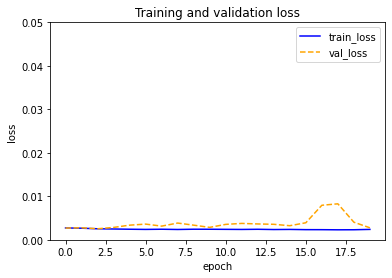

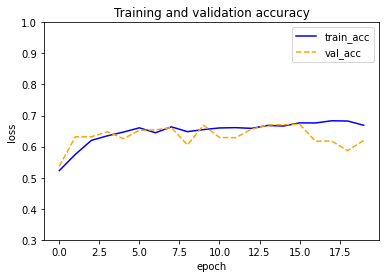

In [37]:
# batch size: 64->256
# after fixed
#data_single, size 350
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'orange', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
# plt.grid()
plt.ylim([0, 0.05])
plt.legend(loc='best')


plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'orange', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
# plt.grid()
plt.ylim([0.3, 1.0])

(0.3, 1.0)

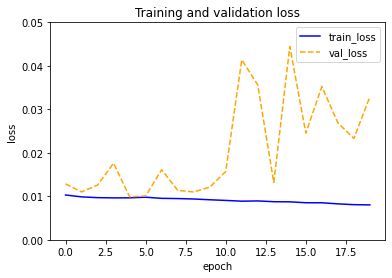

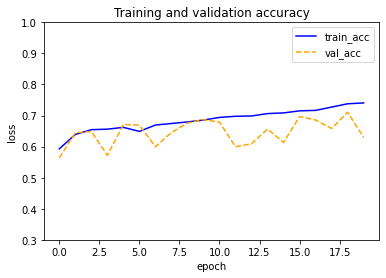

In [22]:

# after fixed
#data_single, size 350
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'orange', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
# plt.grid()
plt.ylim([0, 0.05])
plt.legend(loc='best')


plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'orange', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
# plt.grid()
plt.ylim([0.3, 1.0])

(0.3, 1.0)

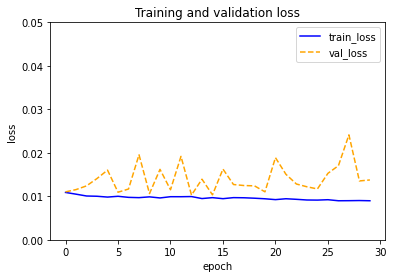

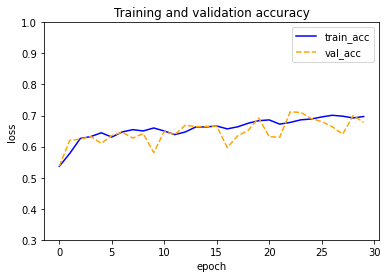

In [15]:

#data_single, size 350
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'orange', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
# plt.grid()
plt.ylim([0, 0.05])
plt.legend(loc='best')


plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'orange', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
# plt.grid()
plt.ylim([0.3, 1.0])

(0.3, 1.0)

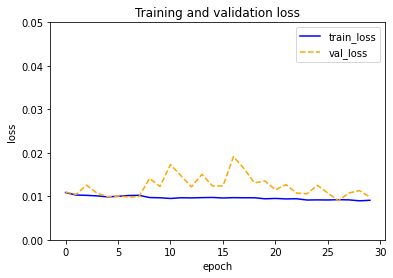

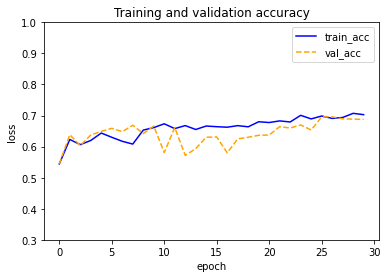

In [15]:


#data_single, size 400
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'orange', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
# plt.grid()
plt.ylim([0, 0.05])
plt.legend(loc='best')


plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'orange', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
# plt.grid()
plt.ylim([0.3, 1.0])

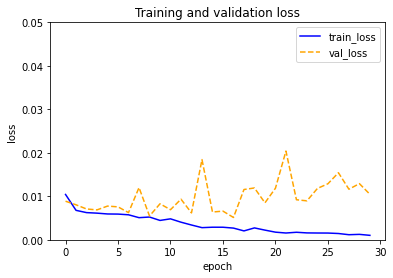

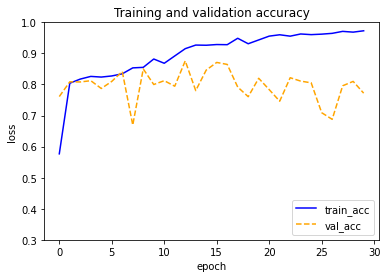

In [113]:
## filter size 5, 3 layers of CONV2D, till 30 epochs, final dense 512 (previous:256)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'orange', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
# plt.grid()
plt.ylim([0, 0.05])
plt.legend(loc='best')


plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'orange', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
# plt.grid()
plt.ylim([0.3, 1.0])
plt.legend(loc='lower right')

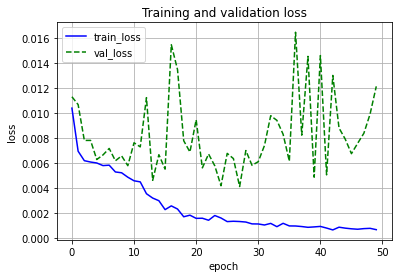

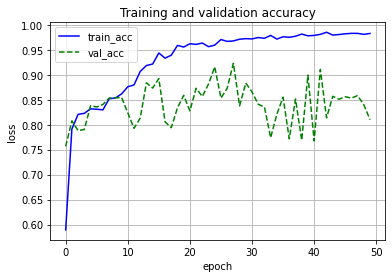

In [91]:
## filter size 5, 3 layers of CONV2D, till 50 epochs, final dense128 (previous:256)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'green', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'green', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
plt.grid()

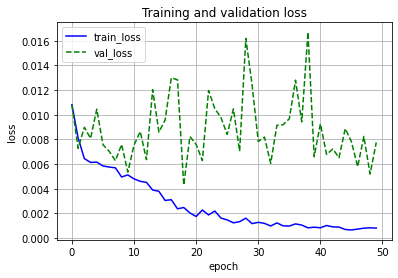

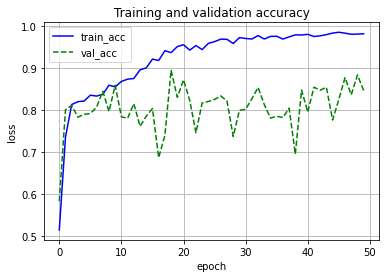

In [76]:
## filter size 5, 3 layers of CONV2D, till 50 epochs

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'green', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'green', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
plt.grid()

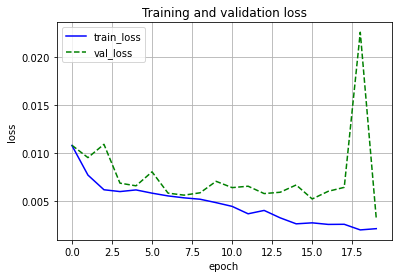

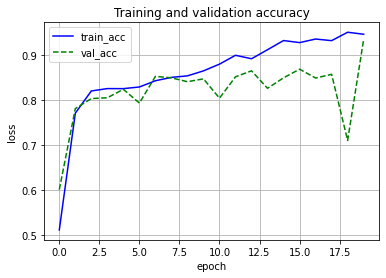

In [46]:
## filter size 5, 3 layers of CONV2D

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'green', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'green', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
plt.grid()

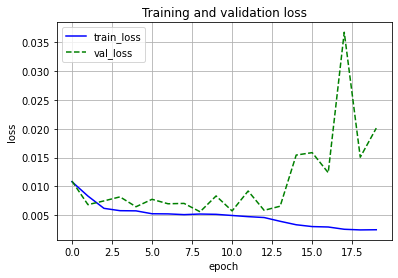

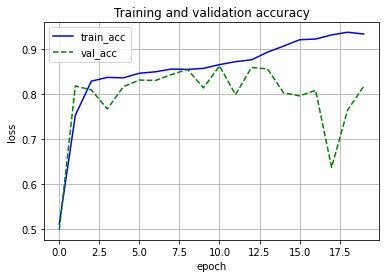

In [31]:
## filter size 3, 3 layers of CONV2D

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'green', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'green', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
plt.grid()

In [332]:
size_check = torch.FloatTensor(10,3,224,224)
features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,192,kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192,384,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
)

In [333]:
print(features(size_check).size())

torch.Size([10, 256, 6, 6])


In [334]:
print(features(size_check).view(size_check.size(0), -1).size())

torch.Size([10, 9216])


In [335]:
fc_size=features(size_check).view(size_check.size(0),-1).size()

In [336]:
print(fc_size)

torch.Size([10, 9216])
